In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Library/CloudStorage/Box-Box/Research/discrete_sr/code/SPIDER_discrete/src')

In [2]:
import numpy as np

from PySPIDER.commons.weight import *
from PySPIDER.commons.utils import save, load
from PySPIDER.discrete.library import *
from PySPIDER.discrete.process_library_terms import *

# load memory profiler
%load_ext memory_profiler

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
from scipy import ndimage
from scipy.signal import windows


# Tunable window size for smoothing
sigma = 100  # Adjust this parameter to control smoothing strength

def smooth_along_time_axis(data, sigma):
    """
    Apply Gaussian smoothing along the time axis (axis 2) of the data.
    
    Parameters:
    - data: array with shape (particles, spatial_dims, time_steps)
    - sigma: std. dev of the Gaussian smoothing window
    
    Returns:
    - smoothed_data: same shape as input, smoothed along time axis
    """
    # Create a 1D Gaussian window that goes to zero at edges
    window_size = sigma * 6 # Standard deviation for Gaussian
    gaussian_window = windows.gaussian(window_size, sigma)
    gaussian_window = gaussian_window / np.sum(gaussian_window)  # Normalize
    
    # Apply 1D convolution along the time axis (axis=2) for each particle and spatial dimension
    smoothed_data = np.zeros_like(data)
    
    for particle in range(data.shape[0]):
        for spatial_dim in range(data.shape[1]):
            # Apply 1D convolution with 'same' mode to preserve time series length
            smoothed_data[particle, spatial_dim, :] = np.convolve(
                data[particle, spatial_dim, :], 
                gaussian_window, 
                mode='same'
            )
    
    return smoothed_data

# Alternative implementation using scipy.ndimage for potentially better performance
def smooth_along_time_axis_ndimage(data, sigma):
    """
    Alternative implementation using scipy.ndimage.gaussian_filter1d
    """
    #window_size = sigma * 6.0  # Convert window size to sigma for Gaussian
    
    # Apply Gaussian filter along axis 2 (time axis)
    smoothed_data = ndimage.gaussian_filter1d(data, sigma=sigma, axis=2, mode='nearest')
    
    return smoothed_data


In [4]:
#data = np.load('LJ/positions_rho_0.30.npz')
#data = np.load('LJ/positions_rho_0.30_savefreq_5.npz')
data = np.load('LJ/positions_rho_0.30_savefreq_3.npz')

positions_orig = data['positions'] 
vs_orig = data['vs']
deltat = data['deltat']
dims = data['dims']

del data

print(positions_orig.shape, vs_orig.shape, deltat, dims)

Np, nt = positions_orig.shape[0], positions_orig.shape[2]
world_size = np.array([dims[0], dims[1], nt])


(9600, 2, 10000) (9600, 2, 10000) 2.539543411945013 [248.66604111 248.66604111]


In [40]:
# Apply smoothing ONLY to velocities to avoid periodic boundary artifacts
print(f"Applying Gaussian smoothing to velocities with sigma {sigma}...")
print(f"Original shapes - positions: {positions_orig.shape}, vs: {vs_orig.shape}")

# Smooth only the velocities
vs = smooth_along_time_axis_ndimage(vs_orig, sigma)

# Compute positions by integrating smoothed velocities with periodic boundaries
def integrate_velocities_periodic(initial_positions, velocities, dt, domain_size):
    """
    Integrate velocities to get positions with periodic boundary conditions.
    
    Parameters:
    - initial_positions: starting positions at t=0, shape (particles, spatial_dims)
    - velocities: velocity time series, shape (particles, spatial_dims, time_steps)
    - dt: time step
    - domain_size: size of periodic domain [Lx, Ly]
    
    Returns:
    - positions: integrated positions with periodic wrapping
    """
    positions = np.zeros_like(velocities)
    positions[:, :, 0] = initial_positions
    
    for t in range(1, velocities.shape[2]):
        # Integrate: x(t+dt) = x(t) + v(t) * dt
        positions[:, :, t] = positions[:, :, t-1] + velocities[:, :, t-1] * dt
        
        # Apply periodic boundary conditions
        for dim in range(2):  # x and y dimensions
            # Wrap positions that exceed domain boundaries
            positions[:, dim, t] = np.mod(positions[:, dim, t], domain_size[dim])
    
    return positions

print("Computing positions by integrating smoothed velocities...")
positions = integrate_velocities_periodic(
    initial_positions=positions_orig[:, :, 0], 
    velocities=vs, 
    dt=deltat, 
    domain_size=dims
)

del positions_orig, vs_orig

print(f"Final shapes - positions: {positions.shape}, vs: {vs.shape}")
print("Velocity smoothing and position integration complete!")
print(f"Domain size: {dims}")
print(f"Position range after integration: x=[{positions[:, 0, :].min():.3f}, {positions[:, 0, :].max():.3f}], y=[{positions[:, 1, :].min():.3f}, {positions[:, 1, :].max():.3f}]")

# # do no smoothing
# positions = positions_orig
# vs = vs_orig


# subsampling
subsample_factor = 10
positions = positions[:, :, ::subsample_factor]
vs = vs[:, :, ::subsample_factor]
deltat *= subsample_factor
nt /= subsample_factor
world_size[2] = nt

print(positions.shape, vs.shape, deltat, dims)

Applying Gaussian smoothing to velocities with sigma 100...
Original shapes - positions: (9600, 2, 10000), vs: (9600, 2, 10000)
Computing positions by integrating smoothed velocities...
Final shapes - positions: (9600, 2, 10000), vs: (9600, 2, 10000)
Velocity smoothing and position integration complete!
Domain size: [248.666 248.666]
Position range after integration: x=[0.000, 248.666], y=[0.000, 248.666]
(9600, 2, 1000) (9600, 2, 1000) 253.9543411945013 [248.666 248.666]


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib import animation
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

# vid_file = 'LJ/n9600rho0_30_sf3_smoothed.mp4'

# fig, ax = plt.subplots(figsize=(6, 6))
# qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

# def animate(i):
#     if i % 10 == 0:
#         print(i)
#     qv.set_offsets(positions[:, :, i])
#     norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
#     qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
#     return qv,

# anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
# FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
# anim.save(vid_file, writer=FFwriter, dpi=100)

In [41]:
%%prun # compute time profiling
#%%memit # memory profiling - doesn't work in VSCode or clones thereof for whatever reason.

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 20 #0.2
corr_T = 500
kernel_sigma = 4 # 0.02
t_sigma = 0#10
cg_res = 1
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
rho_scale=Np/dims[0]/dims[1], irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, 
time_sigma=t_sigma, cg_res=cg_res, deltat=deltat, cutoff=6, cache_primes=True)
#v_est = np.mean(np.abs(vs))*2**0.5
#print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_rho=2)
srd.make_libraries(max_complexity=5, max_rho=2)
#srd.make_libraries(max_complexity=6, max_rho=2)
for irrep in srd.irreps:
    print(irrep, ":", len(srd.libs[irrep].terms))

dom_width = 30 # 0.1
dom_time = 30  # 50
#srd.make_domains(ndomains=10, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
#srd.make_domains(ndomains=100, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4)
srd.make_weights(m=8, qmax=1)
#srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
srd.set_LT_scale(L=corr_L, T=corr_T) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False) #debug=False

Rank 0 : 42
Rank 1 : 50
Antisymmetric rank 2 : 14
Symmetric trace-free rank 2 : 34


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested

         19153877 function calls (17683421 primitive calls) in 252.264 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      428   84.313    0.197   84.313    0.197 {method 'poll' of 'select.poll' objects}
       28   59.800    2.136   59.800    2.136 {method 'write' of '_io.BufferedWriter' objects}
    250/1   51.805    0.207    0.000    0.000 {method 'control' of 'select.kqueue' objects}
   391/27   24.799    0.063   24.794    0.918 {built-in method posix.read}
      204   19.426    0.095   19.427    0.095 {method 'dump' of '_pickle.Pickler' objects}
      168    3.463    0.021    3.463    0.021 {built-in method posix.waitpid}
  252/251    1.157    0.005  350.417    1.396 selectors.py:558(select)
    89760    0.544    0.000    1.826    0.000 arrayprint.py:966(fillFormat)
432480/89760    0.430    0.000    1.044    0.000 arrayprint.py:815(recurser)
    89760    0.354    0.000    0.386    0.000 _ufunc_config.py:410(__enter__

In [ ]:
from scipy.stats._stats import gaussian_kernel_estimate
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

def coarse_grain_slice(t, sigma, field='rho', component=None):
    pt_pos = positions[:, :, t]
    weights = np.ones(pt_pos.shape[0], dtype=np.float64)
    if field == 'v':
        weights *= vs[:, component, t]
    xx, yy = np.meshgrid(range(int(dims[0])), range(int(dims[1])))
    xi = np.vstack([xx.ravel(), yy.ravel()]).T

    sigma_sq = sigma ** 2
    # Check scipy version. If it's lower than 1.10, use inverse_covariance, otherwise use Cholesky
    if int(scipy.__version__.split(".")[0]) <= 1 and int(scipy.__version__.split(".")[1]) < 10:
        inv_cov = np.eye(2) / sigma_sq
    else:
        inv_cov = np.eye(2) * sigma_sq
        inv_cov = np.linalg.cholesky(inv_cov[::-1, ::-1]).T[::-1, ::-1]
    density = gaussian_kernel_estimate['double'](pt_pos, weights[:, None], xi, inv_cov,
                                                 np.float64)
    output = np.reshape(density[:, 0], xx.shape)
    return output

t = 300
sigma = kernel_sigma
rho_cg = coarse_grain_slice(t, sigma, field='rho')
vx_cg = coarse_grain_slice(t, sigma, field='v', component=0)
vy_cg = coarse_grain_slice(t, sigma, field='v', component=1)

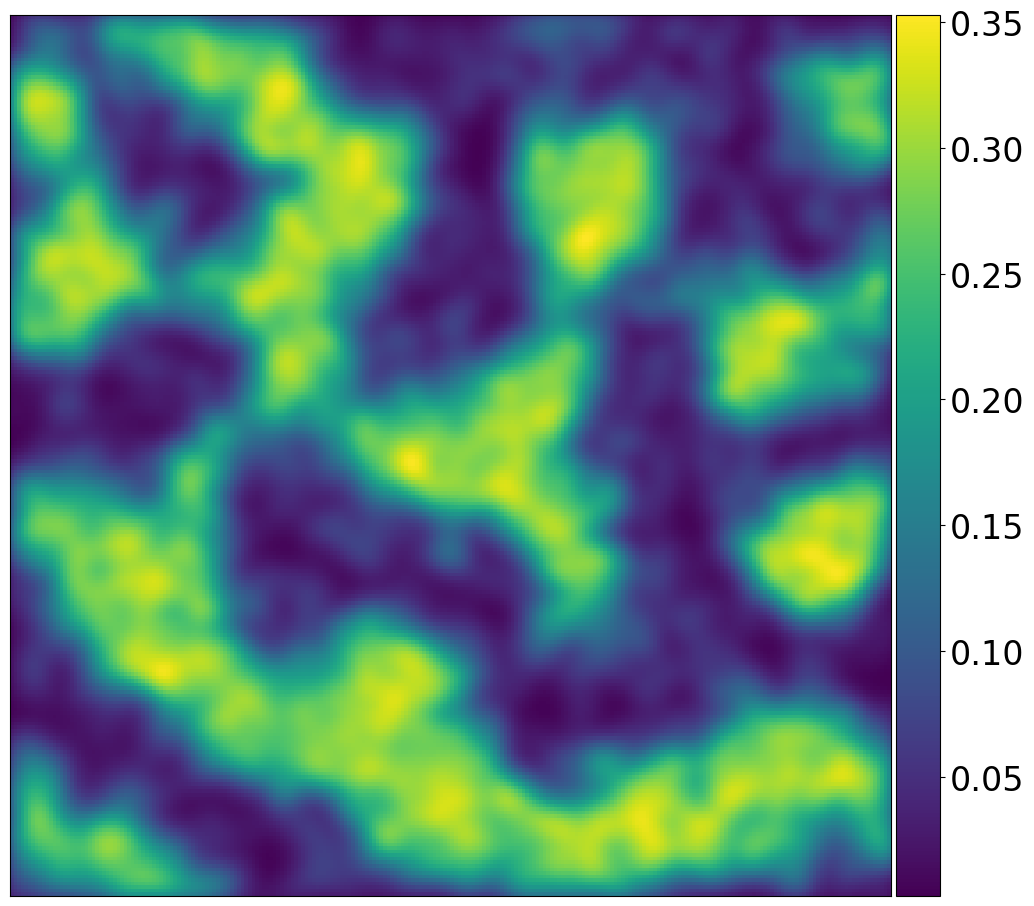

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
im1 = ax1.imshow(rho_cg)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.ax.tick_params(labelsize=24) 

name = f'cg_rho_{sigma}.eps'
plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

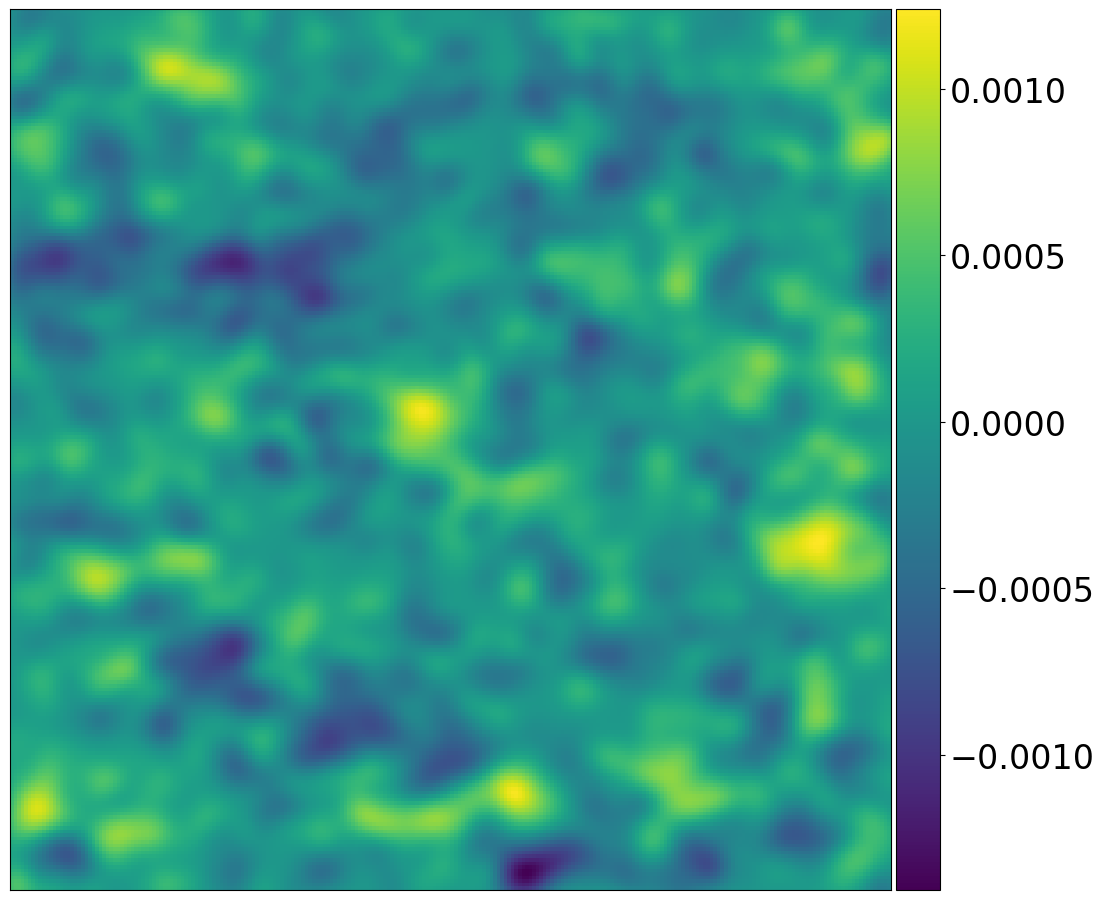

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 12))
im1 = ax1.imshow(vx_cg)

frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.ax.tick_params(labelsize=24) 

name = f'cg_vx_{sigma}.eps'
plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300,

In [42]:
from PySPIDER.commons.identify_models import *

libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    #print(np.linalg.norm(libs[irrep].Q, axis=0))
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
    init = Initializer(method='combinatorial', start_k=3)
    #init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    #res = Residual(residual_type='dominant_balance')
    #res = Residual(residual_type='matrix_relative')
    res = Residual(residual_type='hybrid')
    
    iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
    #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)


eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
    #reg_opts_list, threshold=1e-6, experimental=True, report_accuracy=True,
    reg_opts_list, threshold=3e-2, experimental=True, report_accuracy=True,
    #print_opts={'num_format': '{0:.3g}', 'latex_output': True}
)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.01 s]
Identified model: 1 · ∂t ρ + ∂α ρ[v_α] = 0 (order 3, residual 1.37e-03)
(r_h = 1.37e-03)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 3 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 4 ---
--- 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
for i, res in enumerate(reg_results):
    if len(eqs[i].terms)>1:
        all_lambdas = res.all_lambdas
        print(all_lambdas)
        all_xis = res.all_xis
        xi_values = res.xi
        sublibrary_terms = res.sublibrary
        equations = []
        print(eqs[i].coeffs)
        print([t for (t, c) in zip(res.sublibrary, res.all_xis[4]) if c!=0])
        #equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
        #equation_string = " + ".join(equation_terms)
        equation_string = str(eqs[i].pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
        print(equation_string)
    
        
        plt.figure(figsize=(6, 5))
        #plt.scatter(range(2, len(all_lambdas) + 1), all_lambdas[1:], color='k')#, label="Lambda values") # range(1, 
        max_terms = min(10, len(all_lambdas))
        plt.scatter(range(1, max_terms+1), all_lambdas[:10], color='k')#, label="Lambda values")

        
        # Set log scale for y-axis
        plt.yscale("log")

        fs = 18
        fs2 = 14
        plt.xlabel("$k$", fontsize=fs)
        plt.ylabel("$r_F$", fontsize=fs)
        #plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
        #plt.xticks(range(2, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations
        plt.xticks(range(1, max_terms+1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations

        plt.yticks(fontsize=fs2)
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5) # which="both"

        name = f'discrete_pareto_{i}.eps'
        #plt.savefig(name, bbox_inches='tight', format='eps') # dpi=300, 
        plt.show()

[0.484 0.142 0.139]
(np.float64(1.0), np.float64(-0.5509650904394885))


IndexError: index 4 is out of bounds for axis 0 with size 3

In [ ]:
for k, v in excluded_terms.items():
    print(len(v), v)

8 {∂t² ∂α ρ[v_α], ∂t ∂α ρ[v_α], ∂t ρ · ∂α ρ[v_α], ρ · ∂t ∂α ρ[v_α], ∂α ρ[v_α], ρ · ρ · ∂α ρ[v_α], ρ · ∂α ρ[v_α], ∂α² ∂β ρ[v_β]}
5 {∂t ∂α ∂β ρ[v_β], ∂α ρ · ∂β ρ[v_β], ρ · ∂α ∂β ρ[v_β], ∂α ∂β ρ[v_β], ρ[v_α] · ∂β ρ[v_β]}
1 {∂α ∂β ∂γ ρ[v_γ]}
16 {∂γ² ρ[v_α · v_β], ρ[v_α · v_β], ρ · ρ[v_α] · ρ[v_β], ∂t² ρ[v_α · v_β], ∂α ∂β ∂γ ρ[v_γ], ρ[v_α] · ∂t ρ[v_β], ρ · ρ · ρ[v_α · v_β], ∂t ρ · ∂α ρ[v_β], ∂t ∂α ρ · ρ[v_β], ∂α ∂γ ρ[v_β · v_γ], ∂α ∂β ρ[v_γ · v_γ], ∂t ρ · ρ[v_α · v_β], ρ[v_α] · ρ[v_β], ∂t ρ[v_α · v_β], ρ · ∂t ρ[v_α · v_β], ρ · ρ[v_α · v_β]}


In [ ]:
# from commons.identify_models import *
# import copy

# #srd = load('Q_gauss1024.npy', 1)
# libs = srd.libs

# reg_opts_list = []
# for irrep in srd.irreps:
#     #print(np.linalg.norm(libs[irrep].Q, axis=0))
#     # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
#     scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=1)
#     #init = Initializer(method='combinatorial', start_k=3)
#     #init = Initializer(method='combinatorial', start_k=9999)
#     init = Initializer(method='power', start_k=10)
#     #res = Residual(residual_type='fixed_column', anchor_col=0)
#     #res = Residual(residual_type='dominant_balance')
#     res = Residual(residual_type='hybrid')
    
#     iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
#     #iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=False, max_passes=1)
#     thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#     #thres = Threshold(threshold_type='information', ic=AIC)
    
#     opts = {'scaler': scaler, 'initializer': init, 'residual': res,
#             'model_iterator': iterator, 'threshold': thres}
#     opts['verbose'] = False
#     opts['inhomog'] = False
#     opts['inhomog_col'] = None
#     reg_opts_list.append(opts)

# eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
# #reg_opts_list, threshold=2e-2, experimental=True)
# reg_opts_list, threshold=4e-2, experimental=True)

In [ ]:
print(srd.scale_dict)
for irrep in srd.irreps:
    # don't forget preprocessing
    Q = srd.libs[irrep].Q/srd.libs[irrep].col_weights # reweight columns
    for i in range(Q.shape[0]): # normalize rows
        Q[i, :] /= np.linalg.norm(Q[i, :])
    [U, S, V] = np.linalg.svd(Q)
    print(np.linalg.norm(Q)/max(S))

{'v': {'mean': np.float64(0.006442702085404478), 'std': np.float64(0.006442702085404486)}, 'rho': {'mean': np.float64(1.0), 'std': np.float64(0.6712815151769168)}}
1.1577788016296562
1.674529827254986
1.1516712770696513
1.220113948216143


In [54]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, np.linalg.norm(lib1.Q[:, i])/size, term.complexity)
# print(next(regex_find(lib1.terms, r'∂α ∂β² ρ')))
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
print(next(regex_find(lib1.terms, r'∂β ρ\[v_α · v_β\]')))
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α · v_β · v_β\]')))
print(next(regex_find(lib1.terms, r'∂t³ ρ\[v_α\]'))) 
# print(next(regex_find(lib1.terms, r'∂α ρ\[v_β · v_β\]')))
# print(next(regex_find(lib1.terms, r'∂α ρ')))

0 ρ · ∂α ρ 0.009316006396950304 9141.29514277155 3
1 ρ · ∂α ∂β² ρ 2.3290015992375758e-05 285546.6527806588 5
2 ρ · ∂t ∂α ρ 1.8632012793900607e-05 2689.119930436105 4
3 ρ · ∂t² ∂α ρ 3.7264025587801214e-08 1954.0738957088588 5
4 ρ · ρ[v_α] 0.006442702085404478 561.2470090348397 3
5 ρ · ∂α ∂β ρ[v_β] 3.001012692063663e-06 16647.68122092716 5
6 ρ · ∂β² ρ[v_α] 3.001012692063663e-06 38552.28596242569 5
7 ρ · ∂t ρ[v_α] 2.4008101536509303e-06 1022.224656995451 4
8 ρ · ∂t² ρ[v_α] 4.80162030730186e-09 728.2558096789967 5
9 ρ · ∂β ρ[v_α · v_β] 3.866926145896778e-07 6506.244206020181 5
10 ρ · ∂α ρ[v_β · v_β] 3.866926145896778e-07 17023.7209811508 5
11 ρ · ρ[v_α · v_β · v_β] 2.6742632070787226e-07 3541.162206802285 5
12 ∂α ρ 0.009316006396950304 8673.896972433016 2
13 ∂β ρ · ∂α ∂β ρ 4.3393987594009496e-06 65535.5336858648 5
14 ∂α ρ · ∂β² ρ 4.3393987594009496e-06 109291.01570198749 5
15 ∂α ρ · ∂t ρ 3.4715190075207594e-06 3675.2604232944173 4
16 ∂α ρ · ∂t² ρ 6.943038015041519e-09 1876.9631520498476 5


In [ ]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)

0 ρ 1.0 1
1 ρ · ρ 1.0 2
2 ρ · ∂α² ρ 0.001678203787942292 4
3 ρ · ∂t ρ 0.0013425630303538336 3
4 ρ · ∂t ∂α² ρ 3.356407575884584e-06 5
5 ρ · ∂t² ρ 2.6851260607076672e-06 4
6 ρ · ∂t³ ρ 5.370252121415334e-09 5
7 ρ · ∂α ρ[v_α] 0.00021624334088619028 4
8 ρ · ∂t ∂α ρ[v_α] 4.3248668177238055e-07 5
9 ρ · ρ[v_α · v_α] 4.150841016127521e-05 4
10 ρ · ∂t ρ[v_α · v_α] 5.5727656931291646e-08 5
11 ∂α ρ · ∂α ρ 0.001126547181545543 4
12 ∂α ρ · ∂t ∂α ρ 2.253094363091086e-06 5
13 ∂α ρ · ρ[v_α] 0.00021624334088618999 4
14 ∂α ρ · ∂t ρ[v_α] 2.9032031503400064e-07 5
15 ∂α² ρ 0.001678203787942292 3
16 ∂α² ρ · ∂t ρ 2.253094363091086e-06 5
17 ∂α² ∂β² ρ 4.19550946985573e-06 5
18 ∂t ρ 0.0013425630303538336 2
19 ∂t ρ · ∂t ρ 1.8024754904728688e-06 4
20 ∂t ρ · ∂t² ρ 3.6049509809457374e-09 5
21 ∂t ρ · ∂α ρ[v_α] 2.9032031503400064e-07 5
22 ∂t ρ · ρ[v_α · v_α] 5.5727656931291514e-08 5
23 ∂t ∂α ρ · ρ[v_α] 4.3248668177237997e-07 5
24 ∂t ∂α² ρ 3.356407575884584e-06 4
25 ∂t² ρ 2.6851260607076672e-06 3
26 ∂t² ∂α² ρ 6.7128151

In [ ]:
col_norms = np.linalg.norm(lib0.Q/lib0.col_weights, axis=0)
print(len(col_norms), lib0.Q.shape)
for term, norm in zip(lib0.terms, col_norms/max(col_norms)):
    print(term, norm)

42 (240, 42)
ρ 0.0076079908522464455
ρ · ρ 0.01359584155195063
ρ · ∂α² ρ 0.04685955272420012
ρ · ∂t ρ 0.0010504519847116239
ρ · ∂t ∂α² ρ 0.021736297986248144
ρ · ∂t² ρ 0.0016793689185385097
ρ · ∂t³ ρ 0.0053294001512436935
ρ · ∂α ρ[v_α] 0.006517308123658241
ρ · ∂t ∂α ρ[v_α] 0.010407561673854947
ρ · ρ[v_α · v_α] 0.015122615612743851
ρ · ∂t ρ[v_α · v_α] 0.00716101501592584
∂α ρ · ∂α ρ 0.036693057092119986
∂α ρ · ∂t ∂α ρ 0.00488419515561281
∂α ρ · ρ[v_α] 0.0033064627440352015
∂α ρ · ∂t ρ[v_α] 0.0058044967339869235
∂α² ρ 0.029198963742529914
∂α² ρ · ∂t ρ 0.004574819490276879
∂α² ∂β² ρ 1.0
∂t ρ 0.0008742479994258087
∂t ρ · ∂t ρ 0.00036212270815328714
∂t ρ · ∂t² ρ 0.00024481411251086016
∂t ρ · ∂α ρ[v_α] 0.0022477978829458178
∂t ρ · ρ[v_α · v_α] 0.0019775225165713146
∂t ∂α ρ · ρ[v_α] 0.0019640529847589445
∂t ∂α² ρ 0.018132954814005987
∂t² ρ 0.0014812778401008975
∂t² ∂α² ρ 0.06313190062745806
∂t³ ρ 0.005497063301748398
∂t⁴ ρ 0.02934524438527737
ρ[v_α] · ρ[v_α] 0.0015394123874873666
ρ[v_α] · ∂t 

In [43]:
lt = lib1.terms
print(f'{lt[39]}, {lt[44]}')
scaler = Scaler(sub_inds=[39, 44], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂t ρ[v_α], ∂β ρ[v_α · v_β]
0.2552372478181967 [1.    0.314]


In [44]:
lt = lib0.terms
print(f'{lt[15]}, {lt[25]}')
scaler = Scaler(sub_inds=[15, 25], char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib0.Q, None, scaler, return_xi=True)
print(rh, xi)

NameError: name 'lib0' is not defined

In [47]:
#(24, ∂α ∂β² ρ)
#(39, ∂t ρ[v_α])
#(45, ∂β ρ[v_α · v_β])
#(44, ∂α ρ[v_β · v_β])
#(12, ∂α ρ)
lt = lib1.terms
print(f'{lt[44]}, {lt[24]}, {lt[39]}, {lt[45]}')
scaler = Scaler(sub_inds=[44, 24, 39, 45], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂β ρ[v_α · v_β], ∂α ∂β² ρ, ∂t ρ[v_α], ∂α ρ[v_β · v_β]
0.012811256390711073 [ 7.700e-01 -1.290e-04  1.000e+00 -2.536e-01]


In [56]:
#(24, ∂α ∂β² ρ)
#(39, ∂t ρ[v_α])
#(45, ∂β ρ[v_α · v_β])
#(44, ∂α ρ[v_β · v_β])
#(12, ∂α ρ)
lt = lib1.terms
print(f'{lt[45]}, {lt[43]}, {lt[39]}')
scaler = Scaler(sub_inds=[45, 43, 39], char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
rh, xi = hybrid_residual(lib1.Q, None, scaler, return_xi=True)
print(rh, xi)

∂β ρ[v_α · v_β], ∂t³ ρ[v_α], ∂t ρ[v_α]
0.03682276897659526 [1.223e-05 1.000e+00 1.515e-05]


In [48]:
lib0 = libs[srd.irreps[0]]
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=3)
#init = Initializer(method='combinatorial', start_k=9999)
init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(libs0.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
#opts['inhomog_col'] = 1 # ρ²
opts['inhomog_col'] = 15 # ∂α² ρ
#opts['inhomog_col'] = 25 # ∂t² ρ

remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
rh = hybrid_residual(lib0.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')

∂α² ρ = 0 ; residual: 0.04553101677204356
(r_h = 1.00e+00)


In [52]:
lib1 = libs[srd.irreps[1]]
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=4)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
#res = Residual(residual_type='dominant_balance')
#res = Residual(residual_type='matrix_relative')
res = Residual(residual_type='hybrid')

iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=3)
#iterator = ModelIterator(max_k=len(lib1.terms), backward_forward=True, max_passes=1)

thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 39 # dt rho[v_i]
opts['verbose'] = False

remove_terms = [7]#, 49] # rho * dt rho[v_i], ∂t ρ[v_α · v_β · v_β]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)
rh = hybrid_residual(lib1.Q, reg_result.xi, opts['scaler'])
print(f'(r_h = {rh:.2e})')

∂t ρ[v_α] + 0.9565775376054725 · ∂β ρ[v_α · v_β] = 0 ; residual: 0.03949713942952807
(r_h = 3.95e-02)


[0.004 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
∂t ρ[v_α] + 0.957 · ∂β ρ[v_α · v_β] = 0
['-1.0e+00 ∂t ρ[v_α]']
['-1.0e+00 ∂t ρ[v_α]', '-1.5e-01 ∂β ρ[v_α · v_β]']
['-1.0e+00 ∂t ρ[v_α]', '-1.8e-01 ∂t³ ρ[v_α]', '-1.4e-01 ∂β ρ[v_α · v_β]']
['-9.5e-02 ρ[v_α] · ρ[v_β · v_β]', '-1.0e+00 ∂t ρ[v_α]', '-1.9e-01 ∂t³ ρ[v_α]', '-1.4e-01 ∂β ρ[v_α · v_β]']
['-2.5e-02 ∂t² ∂α ρ', '-9.4e-02 ρ[v_α] · ρ[v_β · v_β]', '-1.0e+00 ∂t ρ[v_α]', '-2.1e-01 ∂t³ ρ[v_α]', '-1.4e-01 ∂β ρ[v_α · v_β]']
['-3.1e-02 ∂t² ∂α ρ', '-8.9e-02 ρ[v_α] · ρ[v_β · v_β]', '-1.0e+00 ∂t ρ[v_α]', '-3.1e-03 ∂t ∂β² ρ[v_α]', '-1.8e-01 ∂t³ ρ[v_α]', '-1.4e-01 ∂β ρ[v_α · v_β]']
['-9.9e-04 ρ · ∂β² ρ[v_α]', '-2.9e-02 ∂t² ∂α ρ', '-1.2e-01 ρ[v_α] · ρ[v_β · v_β]', '-1.0e+00 ∂t ρ[v_α]', '-3.1e-03 ∂t ∂β² ρ[v_α]', '-1.8e-01 ∂t³ ρ[v_α]', '-1.3e-01 ∂β ρ[v_α · v_β]']
['-9.5e-04 ρ · ∂β² ρ[v_α]', '-6.0e-01 ∂t² ∂α ρ', '-1.1e-01 ρ[v_α] · ρ[v_β · v_β]', '-1.0e+00 ∂t ρ[v_α]', '-3.1e-03 ∂t ∂β² ρ[v_α]', '-9.2e-02 ∂t ∂α ∂β ρ[v_β]', '-1.9e-01 ∂t³ ρ[v

/var/folders/p_/dc9h9qcj62qgv461rz72zx_80000gn/T/ipykernel_19617/1501462611.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


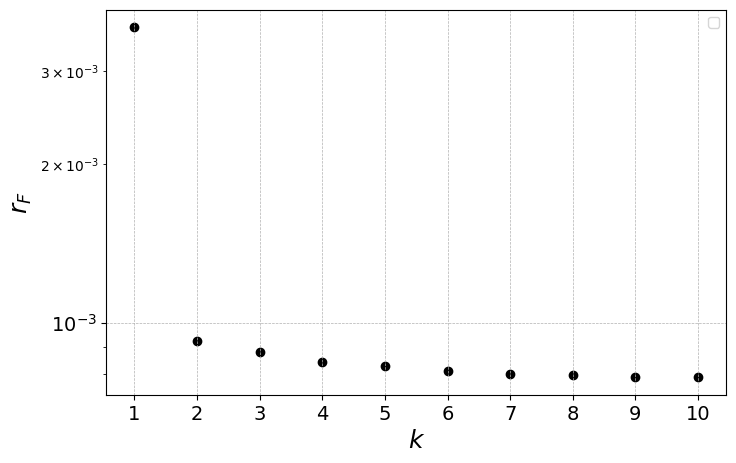

In [50]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = False
res = reg_result
all_lambdas = res.all_lambdas
print(all_lambdas)
all_xis = res.all_xis
xi_values = res.xi
sublibrary_terms = [term for i, term in enumerate(lib1.terms) if i in opts['scaler'].sub_inds]
equations = []
#print(eqs[i].coeffs)
#equation_terms = [f"{xi:.1e} {term}" for xi, term in zip(xi_values, sublibrary_terms) if abs(xi) > 1e-15]
#equation_string = " + ".join(equation_terms)
equation_string = str(eqn.pstr(**{'num_format': '{0:.3g}', 'latex_output': False}))
print(equation_string)
for xi in all_xis:
   print([f"{c:.1e} {term}" for c, term in zip(xi, sublibrary_terms) if abs(c) > 1e-15])

plt.figure(figsize=(8, 5))
#plt.scatter(range(2, len(all_lambdas) + 1), all_lambdas[1:], color='k')#, label="Lambda values") # range(1, 
plt.scatter(range(1, len(all_lambdas) + 1), all_lambdas, color='k')#, label="Lambda values")


# Set log scale for y-axis
plt.yscale("log")

fs = 18
fs2 = 14
plt.xlabel("$k$", fontsize=fs)
plt.ylabel("$r_F$", fontsize=fs)
#plt.title(f"Equation: {equation_string}")  # Use the computed equation as the title
#plt.xticks(range(2, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations
plt.xticks(range(1, len(all_lambdas) + 1), fontsize=fs2)  # Ensure x-axis ticks match the number of equations

plt.yticks(fontsize=fs2)
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5) # which="both"
        

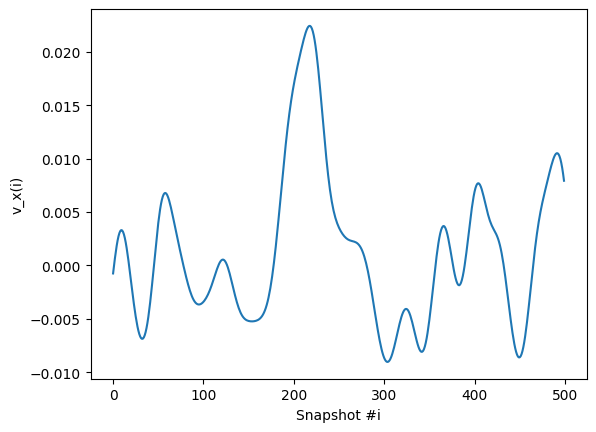

In [ ]:
plt.plot(vs[1, 0, :500])
plt.xlabel('Snapshot #i')
plt.ylabel('v_x(i)')
#plt.title('vs[0, 0, :] vs Time')
plt.show()